<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/HT_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [8]:
# ✅ Imports
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.model_selection import train_test_split

# ✅ Dataset setup
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}
IMG_SIZE = 128  # Reduced image size for faster processing

X, y = [], []

# ✅ Load & preprocess images
for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        img = cv2.imread(image_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Loaded {len(X)} images.")

# ✅ Load VGG19 base
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# ✅ Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# ✅ Data augmentation with minimal settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# ✅ Callbacks
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# ✅ Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


✅ Loaded 497 images.
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1867 - loss: 2.6629
Epoch 1: val_accuracy improved from -inf to 0.21000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.1867 - loss: 2.6644 - val_accuracy: 0.2100 - val_loss: 2.5179 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2613 - loss: 2.3616
Epoch 2: val_accuracy improved from 0.21000 to 0.30000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.2607 - loss: 2.3674 - val_accuracy: 0.3000 - val_loss: 1.7838 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2710 - loss: 2.3280
Epoch 3: val_accuracy improved from 0.30000 to 0.35000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.2705 - loss: 2.3279 - val_accuracy: 0.3500 - val_loss: 1.5579 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2902 - loss: 2.2479
Epoch 4: val_accuracy improved from 0.35000 to 0.39000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.2908 - loss: 2.2443 - val_accuracy: 0.3900 - val_loss: 1.4464 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3413 - loss: 1.9938
Epoch 5: val_accuracy improved from 0.39000 to 0.42000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.3414 - loss: 1.9943 - val_accuracy: 0.4200 - val_loss: 1.3701 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3193 - loss: 2.0497
Epoch 6: val_accuracy improved from 0.42000 to 0.45000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.3205 - loss: 2.0456 - val_accuracy: 0.4500 - val_loss: 1.3296 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4146 - loss: 1.7332
Epoch 7: val_accuracy improved from 0.45000 to 0.48000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.4153 - loss: 1.7288 - val_accuracy: 0.4800 - val_loss: 1.3082 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3954 - loss: 1.7428
Epoch 8: val_accuracy did not improve from 0.48000
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.3963 - loss: 1.7384 - val_accuracy: 0.4800 - val_loss: 1.2825 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4113 - loss: 1.6496
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_accuracy did not improve from 0.48000
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.4117 - loss: 1.6494 - val_accuracy: 0.4800 - val_loss: 1.2344 - learning_rate: 1.0000e-04
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3824 - loss: 1.6468
Epoch 10: val_accuracy improved from 0.48000 to 0.51000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.3838 - loss: 1.6459 - val_accuracy: 0.5100 - val_loss: 1.2246 - learning_rate: 5.0000e-05
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4667 - loss: 1.4509
Epoch 11: val_accuracy improved from 0.51000 to 0.52000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.4659 - loss: 1.4535 - val_accuracy: 0.5200 - val_loss: 1.2156 - learning_rate: 5.0000e-05
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4628 - loss: 1.4615
Epoch 12: val_accuracy improved from 0.52000 to 0.53000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.4629 - loss: 1.4630 - val_accuracy: 0.5300 - val_loss: 1.2050 - learning_rate: 5.0000e-05
Epoch 13/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4692 - loss: 1.5231
Epoch 13: val_accuracy improved from 0.53000 to 0.54000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.4699 - loss: 1.5205 - val_accuracy: 0.5400 - val_loss: 1.1962 - learning_rate: 5.0000e-05
Epoch 14/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4695 - loss: 1.3682
Epoch 14: val_accuracy improved from 0.54000 to 0.55000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.4693 - loss: 1.3697 - val_accuracy: 0.5500 - val_loss: 1.1894 - learning_rate: 5.0000e-05
Epoch 15/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4560 - loss: 1.5922
Epoch 15: val_accuracy did not improve from 0.55000
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.4570 - loss: 1.5869 - val_accuracy: 0.5500 - val_loss: 1.1738 - learning_rate: 5.0000e-05
Epoch 16/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5577 - loss: 1.2870
Epoch 16: val_accuracy improved from 0.55000 to 0.56000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.5574 - loss: 1.2880 - val_accuracy: 0.5600 - val_loss: 1.1705 - learning_rate: 5.0000e-05
Epoch 17/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5289 - loss: 1.3082
Epoch 17: val_accuracy did not improve from 0.56000
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.5276 - loss: 1.3116 - val_accuracy: 0.5600 - val_loss: 1.1610 - learning_rate: 5.0000e-05
Epoch 18/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5366 - loss: 1.3867
Epoch 18: val_accuracy improved from 0.56000 to 0.57000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.5365 - loss: 1.3851 - val_accuracy: 0.5700 - val_loss: 1.1543 - learning_rate: 5.0000e-05
Epoch 19/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5485 - loss: 1.2446
Epoch 19: val_accuracy did not improve from 0.57000
25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.5475 - loss: 1.2464 - val_accuracy: 0.5700 - val_loss: 1.1457 - learning_rate: 5.0000e-05
Epoch 20/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5076 - loss: 1.3192
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: val_accuracy did not improve from 0.57000
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.5085 - loss: 1.3175 - val_accuracy: 0.5700 - val_loss: 1.1378 - learning_rate: 5.0000e-05
Epoch 21/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5155 - loss: 1.4089
Epoch 21: val_accuracy did not improve from 0.57000
25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.5152 - loss: 1.4064 - val_ac

25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.5874 - loss: 1.1887 - val_accuracy: 0.5800 - val_loss: 1.1317 - learning_rate: 1.2500e-05
Epoch 24/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5645 - loss: 1.3022
Epoch 24: val_accuracy did not improve from 0.58000
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.5636 - loss: 1.3020 - val_accuracy: 0.5800 - val_loss: 1.1285 - learning_rate: 1.2500e-05
Epoch 25/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5235 - loss: 1.3479
Epoch 25: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 25: val_accuracy did not improve from 0.58000
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.5238 - loss: 1.3471 - val_accuracy: 0.5800 - val_loss: 1.1329 - learning_rate: 1.2500e-05
Epoch 26/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5309 - loss: 1.4302
Epoch 26: val_accuracy did not improve from 0.58000
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5308 - loss: 1.4280 - val_acc

In [9]:
# ✅ Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"🎯 Final Test Accuracy: {accuracy:.4f}")
print(f"💾 Final Test Loss: {loss:.4f}")

# ✅ Save model
model.save("vgg19_tuned_ovarian_model.h5")
print("✅ Model saved as 'vgg19_tuned_ovarian_model.h5'")


4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.5476 - loss: 1.1600


🎯 Final Test Accuracy: 0.5800
💾 Final Test Loss: 1.1317
✅ Model saved as 'vgg19_tuned_ovarian_model.h5'


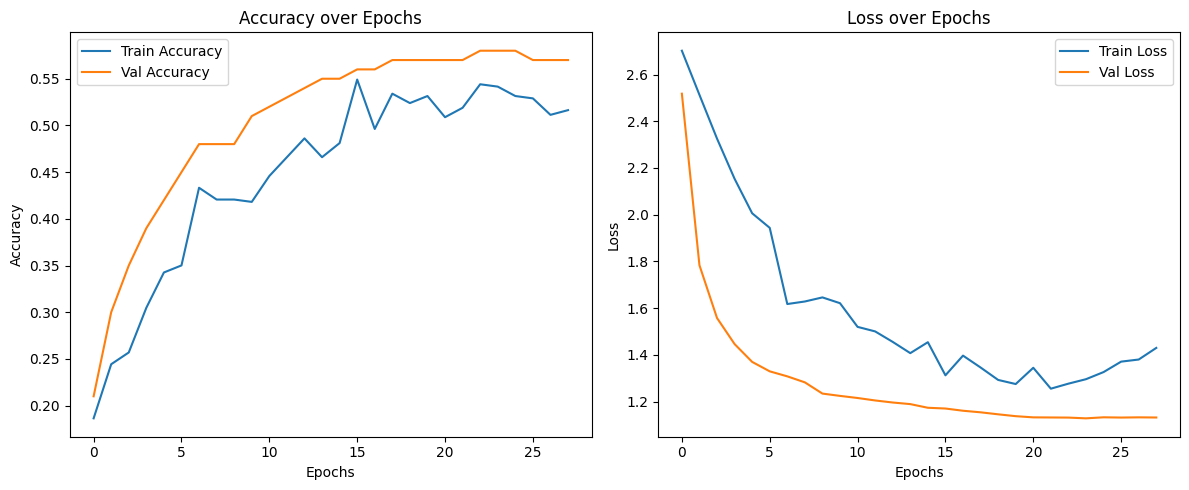

In [11]:
# ✅ Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()